In [1]:
#from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
from tqdm import tqdm
import torch
import numpy as np

from random import randint

# Splits data into batches of defined size
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import torchvision.utils as vutils

/raid/home/kawinm/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# @title alternative dataset: faces (CelebA) - uncomment to run 
faces = load_dataset('huggan/CelebA-faces')['train']

# Dsprites
dataset_zip = np.load('data/dsprites/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

dsprites = torch.Tensor(dataset_zip['imgs'])
dsprites_class = torch.Tensor(dataset_zip['latents_classes'])
dsprites = dsprites.unsqueeze(dim=1)

In [135]:
DATASET = 'dsprites' # or 'faces'

if DATASET == 'faces':
    dataset = faces
    input_channel = 3
    input_height  = 218
    input_width   = 178
    z_dim         = 512
else:
    dataset = dsprites
    input_channel = 1
    input_height  = 64
    input_width   = 64
    z_dim         = 1024

batch_size = 128
pil_to_tensor = transforms.ToTensor()

def collate_fn(instn):

    dataset = []
    for i in instn:
        dataset.append(pil_to_tensor(i['image']).unsqueeze(dim=0))
    
    data_batch = torch.Tensor(len(instn),dataset[0].shape[1], dataset[0].shape[2], dataset[0].shape[3])
    db = torch.cat(dataset, out=data_batch)
    return db

if DATASET == 'dsprites':
    loader = DataLoader(dataset, batch_size, shuffle=True)
else:
    loader = DataLoader(dataset, batch_size, shuffle=True, collate_fn=collate_fn)

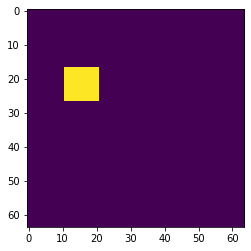

In [5]:
t = transforms.ToTensor()

if DATASET == 'dsprites':
    plt.imshow(dataset[6][0])
else:
    plt.imshow(dataset[6]['image'])

In [6]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
device = torch.device("cuda:1")
class VAE(torch.nn.Module):
    def __init__(self, input_channel, input_height, input_width):
        super().__init__()

        self.beta = 1

        self.input_height = input_height
        self.input_width  = input_width

        self.encoder = torch.nn.Sequential(
            nn.Conv2d(input_channel, 4, kernel_size= 4, stride= 1, padding  = 1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(),
            nn.Conv2d(4, 8, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),
            nn.Conv2d(8, 16, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, kernel_size= 4, stride= 2, padding  = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
        )

        if input_channel == 3:
            self.output_height = 14
            self.output_width = 12
        else:
            self.output_height = 7
            self.output_width = 7

        self.mu = torch.nn.Linear(32*self.output_height*self.output_width, z_dim)
        self.sigma = torch.nn.Linear(32*self.output_height*self.output_width, z_dim)

        self.z_back = torch.nn.Linear(z_dim, 32*self.output_height*self.output_width)

        self.mu_z = torch.zeros(1, 32)
        self.sigma_z = torch.ones(1, 32)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)

        self.log_scale = torch.nn.Parameter(torch.Tensor([0.0]))
         
        self.decoder = torch.nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size= 4, stride= 1, padding  = 1, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size= 4, stride= 2, padding  = 1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 4, kernel_size= 4, stride= 2, padding  = 1, output_padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.ConvTranspose2d(4, input_channel, kernel_size= 4, stride= 2, padding  = 1, output_padding=1),
            nn.BatchNorm2d(input_channel),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, sigma):
        z = mu + sigma * self.N.sample(mu.shape)
        return z
 
    def forward(self, x, latent=False):
        # Parameters of Q(z|x)
        encoded = self.encoder(x)
        encoded = torch.flatten(encoded, start_dim=1)
        
        mu = self.mu(encoded)
        sigma = torch.exp(self.sigma(encoded) + 1e-5) # or use softplus , also have a lowerbound for sigma

        # Reparameterize trick
        z = self.reparameterize(mu, sigma)

        if latent:
            return z
            
        res = self.z_back(z)
        res = res.reshape(-1, 32, self.output_height, self.output_width)
        
        # Parameters of P(x|z)
        decoded = self.decoder(res)
        return decoded[:, :, :self.input_height, :self.input_width], z, mu, sigma

    def loss(self, xb_dash, xb, z, mu, sigma, loss_fn, kl_fn):
        recons_loss = loss_fn(xb_dash, xb)
        
        q = torch.distributions.Normal(mu, sigma)
        
        kld_loss = torch.mean(torch.distributions.kl.kl_divergence(q, self.N))
        #kld_loss = torch.mean(torch.sum( q.log_prob(z) - self.N.log_prob(z), dim=1), dim = 0)
        #kld_loss = torch.mean(-0.5 * torch.sum(1 + sigma - mu ** 2 - sigma.exp(), dim = 1), dim = 0)
        loss = recons_loss + (kld_loss * (z_dim / (input_channel*input_height*input_width))) # 469 = Number of batches
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':kld_loss}

In [7]:
# Model Initialization
model = VAE(input_channel, input_height, input_width)

#device = torch.device("cuda:0")
model.to(device)
 
# Validation using MSE Loss function
loss_fn = torch.nn.MSELoss()
cross_entropy_fn = torch.nn.CrossEntropyLoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [15]:
max_epochs = 10

for e in range(1, max_epochs+1):
    epoch_loss = 0
    epoch_kl_loss = 0

    iterator = tqdm(loader)
    for xb in iterator:
        xb = xb.to(device)
        
        xb_dash, z, mu, sigma = model(xb)

        loss = model.loss(xb_dash, xb, z, mu, sigma, loss_fn, cross_entropy_fn)
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        epoch_loss += float(loss['Reconstruction_Loss']) 
        epoch_kl_loss += float(loss['KLD'])
        iterator.set_postfix({"Recons": loss['Reconstruction_Loss'].item(), "KLD":loss['KLD'].item()} )
      
    print("Epoch loss: ", e, epoch_loss, epoch_kl_loss)
    if DATASET == 'dsprites':
        torch.save(model.state_dict(), "vae_dsprites_"+str(model.beta)+".pth")
    else:
        torch.save(model.state_dict(), "vae_celeba_"+str(model.beta)+".pth")

100%|██████████| 3687/3687 [00:55<00:00, 66.53it/s, Recons=0.0103, KLD=0.0156] 


Epoch loss:  1 128.18207303900272 64.9771645879373


100%|██████████| 3687/3687 [00:54<00:00, 67.14it/s, Recons=0.00615, KLD=0.0145]


Epoch loss:  2 27.29291972052306 54.014897904358804


100%|██████████| 3687/3687 [00:54<00:00, 67.22it/s, Recons=0.00522, KLD=0.0149]


Epoch loss:  3 20.35951164038852 55.51558361295611


100%|██████████| 3687/3687 [00:54<00:00, 67.35it/s, Recons=0.00482, KLD=0.0145]


Epoch loss:  4 18.72947671683505 56.312611791305244


100%|██████████| 3687/3687 [00:54<00:00, 67.47it/s, Recons=0.00503, KLD=0.015] 


Epoch loss:  5 17.954970670863986 56.65767396427691


100%|██████████| 3687/3687 [00:54<00:00, 67.44it/s, Recons=0.00464, KLD=0.015] 


Epoch loss:  6 17.521529713179916 56.82688988931477


100%|██████████| 3687/3687 [00:55<00:00, 66.84it/s, Recons=0.00475, KLD=0.0153]


Epoch loss:  7 17.191173747647554 56.955687461420894


100%|██████████| 3687/3687 [00:54<00:00, 67.13it/s, Recons=0.00467, KLD=0.0154]


Epoch loss:  8 16.973020352888852 57.0100664710626


100%|██████████| 3687/3687 [00:54<00:00, 67.38it/s, Recons=0.00453, KLD=0.0152]


Epoch loss:  9 16.765724989119917 57.043746064417064


100%|██████████| 3687/3687 [00:55<00:00, 66.62it/s, Recons=0.0044, KLD=0.0153] 


Epoch loss:  10 16.599714532028884 57.06709076091647


In [139]:
#import sklearn.mixture as sk
# Marginal Likelihood:
#GMM = sk.GaussianMixture(n_components=2)
loss_fn_p = nn.MSELoss(reduction='none')
model.eval()
for xb in loader:
    xb = xb.to(device)[0].unsqueeze(dim=0)
    xb_dash, z, mu, sigma = model(xb)

    for i in range(127):
        xb_dash_sam, z_sample, mul, sigmal = model(xb)
        z = torch.cat((z, z_sample), dim=0)
        xb_dash = torch.cat((xb_dash, xb_dash_sam), dim=0)

    q = torch.distributions.Normal(mu, sigma)
    p_z = torch.logsumexp(model.N.log_prob(z), dim=1)
    #q_z = torch.Tensor(GMM.score_samples(z.detach().cpu().numpy())).to(device)
    q_z = torch.logsumexp(q.log_prob(z), dim=1)
    p_x_z = torch.mean(torch.flatten(loss_fn_p(xb_dash, xb), start_dim=1), dim=1)
    print("Marginal likelihood: ", torch.exp(torch.mean(-q_z + p_z + p_x_z)))
    break

Marginal likelihood:  tensor(0.9690, device='cuda:1', grad_fn=<ExpBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


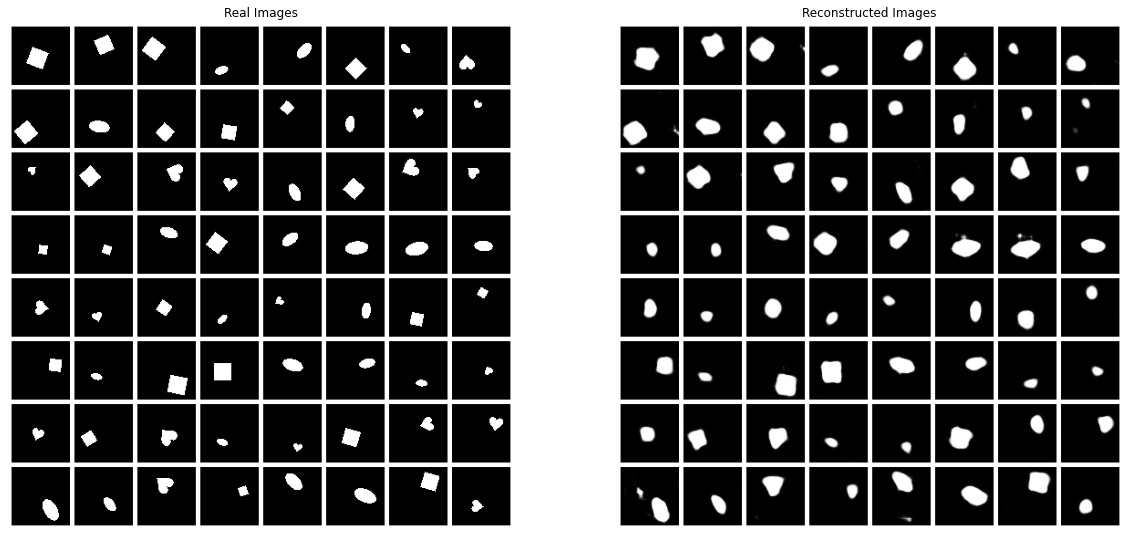

In [143]:
for xb in loader:
    xb = xb.to(device)
    reel_batch, z, mu, sigma = model(xb)
    break
#res = model.z_back(z)
#res = res.reshape(-1, 32, model.output_height, model.output_width)
#reel_batch = model.decoder(res)
#reel_batch = reel_batch[:, :, :model.input_height, :model.input_width]
#reel_batch = reel_batch * 255
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(xb[:64], padding=5, nrow=8, pad_value=255, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
plt.imshow(np.transpose(vutils.make_grid(reel_batch[:64], padding=5, nrow=8, pad_value=255, normalize=True).cpu(),(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


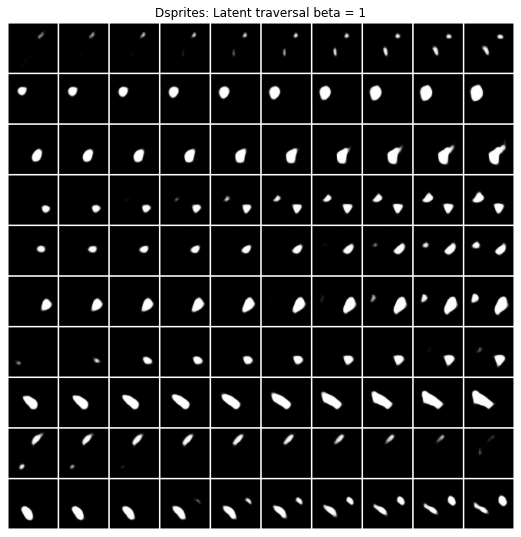

In [62]:
xb = next(iter(loader)).to(device)[:100]
xb_dash, z, mu, sigma = model(xb)

for i in range(100):
    if i % 10 == 0:
        y = torch.randint(low=0, high=511, size=(128,))
        continue
    else:
        z[i] = z[i- (i%10)]
        z[i][y] = z[i][y] + 0.5*(i%10)

res = model.z_back(z)
res = res.reshape(-1, 32, model.output_height, model.output_width)
reel_batch = model.decoder(res)
reel_batch = reel_batch[:, :, :model.input_height, :model.input_width]
reel_batch = reel_batch * 255
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Dsprites: Latent traversal beta = "+str(model.beta))
plt.imshow(np.transpose(vutils.make_grid(reel_batch[:100], padding=2, nrow=10, pad_value=255, normalize=True).cpu(),(1,2,0)))

In [121]:
model = VAE(input_channel, input_height, input_width)

model.load_state_dict(torch.load("vae_dsprites_1.pth"))
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=1568, out_features=1024, bias=True)
  (sigma): Linear(in_features=1568, out_features=1024, bias=True)
  (z_back): Linear(in_feat

In [ ]:
class_data = []
for y in range(1, 6):
    for i in range(len(dataset)-256):
        cur_x  = dataset[i].unsqueeze(dim=0).to(device)
        xb_dash, z1, mu, sigma = model(cur_x)
        cur_y = dsprites_class[i][y]
        for j in range(i+1, len(dataset)):
            if dsprites_class[j][y] == cur_y:
                cur_x  = dataset[j].unsqueeze(dim=0).to(device)
                xb_dash, z2, mu, sigma = model(cur_x)
                z = z1 - z2
                break
        class_data.append((z, y))

In [123]:
def collate_fn(instn):

    z, labels = [i[0].detach().cpu().numpy() for i in instn], [i[1] for i in instn]
    
    labels = torch.Tensor(labels)
    z = torch.Tensor(z)
    return (z, labels)

def split_indices(n, val_pct):
    # Determine size of Validation set
    n_val = int(val_pct * n)

    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

train_indices, val_indices = split_indices(len(class_data), 0.1)

train_sampler   = SubsetRandomSampler(train_indices)
train_loader    = DataLoader(class_data, batch_size, sampler=train_sampler, collate_fn=collate_fn)

val_sampler     = SubsetRandomSampler(val_indices)
val_loader      = DataLoader(class_data, batch_size, sampler=val_sampler, collate_fn=collate_fn)

In [125]:
class classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = torch.nn.Linear(1024, 5)
    
    def forward(self, Xb):
        x = self.lin1(Xb)
        x = torch.sigmoid(x)
        return x

In [131]:
classi = classifier()
classi.to(device)
loss = F.cross_entropy
# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(classi.parameters(), lr = 1e-2)

In [ ]:
epo = 10

for ep in range(epo):
    kk = 0
    epo_loss = 0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device).long() -1

        y = classi(xb).squeeze(dim=1)
        los = loss(y, yb)
        optimizer.zero_grad()
        los.backward()
        optimizer.step()


        kk += 1
        epo_loss += float(los)
    
    print(ep, epo_loss)

In [ ]:
from sklearn.metrics import classification_report

epo_loss = 0
pred, inp = [], []
for xb, yb in val_loader:
    xb = xb.to(device)
    yb = yb.to(device).long() -1

    y = classi(xb).squeeze(dim=1)

    epo_loss += float(los)

    pred.extend(torch.argmax(y, dim=1).cpu().detach().numpy())
    inp.extend(yb.cpu().detach().numpy())

print("Disentanglement Metric: ", classification_report(pred, inp))
# 68, 59, 71

In [ ]:
# https://adamcobb.github.io/journal/hamiltorch.html
#https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed

# Large batch size = better loss (200 vs 100) Reason: Better sample estimates for KL